In [0]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='8', unit_scale=True, miniters=1, desc='CIFAT-10 DATASET') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
def load_cifar_10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels


In [0]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cifar_10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}, {} is out of range'.format(len(features), batch_id, sample_id))
        return None
    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}): {}'.format(key, label_names[key].upper(), value))
    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min value: {} Max value: {}'.format(key, label_names[key].upper(), value))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.imshow(sample_image)

    


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE): 994
Label Counts of [1](AUTOMOBILE): 1042
Label Counts of [2](BIRD): 965
Label Counts of [3](CAT): 997
Label Counts of [4](DEER): 990
Label Counts of [5](DOG): 1029
Label Counts of [6](FROG): 978
Label Counts of [7](HORSE): 1015
Label Counts of [8](SHIP): 961
Label Counts of [9](TRUCK): 1029

Example of Image 7000:
Image - Min value: 9 Max value: TRUCK
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


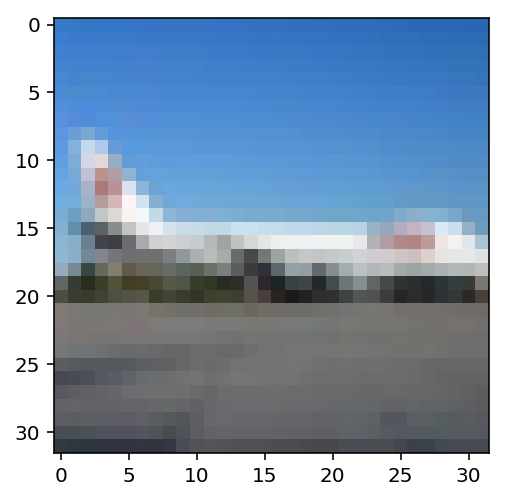

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [0]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x - min_val) / (max_val - min_val)
    return x

In [0]:
def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    return encoded

In [0]:
def preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)
    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cifar_10_batch(cifar10_dataset_folder_path, batch_i)

        index_of_validation = int(len(features) * 0.1)

        preprocess_and_save(normalize, one_hot_encode,
            features[:-index_of_validation], labels[:-index_of_validation],
            'preprocess_batch_' + str(batch_i) + '.p')
            
        valid_labels.extend(labels[-index_of_validation:])
        valid_features.extend(labels[-index_of_validation:])

    preprocess_and_save(normalize, one_hot_encode,
        np.array(valid_features), np.array(valid_labels),
        'preprocess_validation.p')
        
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    preprocess_and_save(normalize, one_hot_encode,
        np.array(test_features), np.array(test_labels),
        'preprocess_training.p')

In [0]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [0]:
import pickle
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [0]:
import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [0]:
def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    ## 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)
    
    ## 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
    
    ## 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv2)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    ## 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    ## 9
    flat = tf.contrib.layers.flatten(conv4_bn) 
    
    ## 10
    full1 = tf.contrib.layers.fully_conected(input=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    ## 11
    full2 = tf.contrib.layers.fully_conected(input=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    ## 12
    full3 = tf.contrib.layers.fully_conected(input=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)
    
    ## 13
    full4 = tf.contrib.layers.fully_conected(input=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)
    
    ## 14
    out = tf.contrib.layers.fully_conected(inputs=full3, num_outputs=10, activation_fn=None)
    return out


In [0]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [54]:
logits = conv_net(x, keep_prob)
model = tf.indentity(logits, name='logits')

cost = tf.reduce_mean(tf.nn.tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Use keras.layers.flatten instead.


AttributeError: ignored

In [0]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer,
        feed_dict={
            x: feature_batch,
            y: label_batch,
            keep_prob: keep_probability
        })

In [0]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost,
        feed_dict={
            x: feature_batch,
            y: label_batch,
            keep_prob: 1.
        })
    valid_acc = sess.run(accuracy,
        feed_dict={
            x: valid_features,
            y: valid_labels,
            keep_prob: 1.
        })
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [0]:
def batch_features_labels(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    return batch_features_labels(features, labels, batch_size)